# Notebook para todas as redes usando multclasses

In [21]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
#from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from googlenet_pytorch import GoogLeNet 


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [23]:
test = 2

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [25]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [26]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    #writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            #writer.add_scalar('training loss', loss, global_step=step)
            #writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.title('Loss in Validation Dataset')
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [27]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [29]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    #
    #googlenet, shufflenet, mobilenet 
    #

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "shufflenet":
        """ shufflenet
        """
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "mobilenet":
        """ mobilenet
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [30]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4627 Acc: 0.8371
val Loss: 0.2547 Acc: 0.9269

Epoch 1/99
----------
train Loss: 0.2540 Acc: 0.9164
val Loss: 0.2098 Acc: 0.9357

Epoch 2/99
----------
train Loss: 0.2173 Acc: 0.9306
val Loss: 0.1776 Acc: 0.9514

Epoch 3/99
----------
train Loss: 0.1964 Acc: 0.9336
val Loss: 0.1767 Acc: 0.9469

Epoch 4/99
----------
train Loss: 0.1860 Acc: 0.9373
val Loss: 0.1586 Acc: 0.9527

Epoch 5/99
----------
train Loss: 0.1826 Acc: 0.9393
val Loss: 0.1415 Acc: 0.9581

Epoch 6/99
----------
train Loss: 0.1700 Acc: 0.9440
val Loss: 0.1348 Acc: 0.9606

Epoch 7/99
----------
train Loss: 0.1646 Acc: 0.9440
val Loss: 0.1340 Acc: 0.9589

Epoch 8/99
----------
train Loss: 0.1594 Acc: 0.9473
val Loss: 0.1499 Acc: 0.9506

Ep

train Loss: 0.1037 Acc: 0.9627
val Loss: 0.0906 Acc: 0.9680

Epoch 95/99
----------
train Loss: 0.1039 Acc: 0.9645
val Loss: 0.0803 Acc: 0.9726

Epoch 96/99
----------
train Loss: 0.1037 Acc: 0.9656
val Loss: 0.0895 Acc: 0.9726

Epoch 97/99
----------
train Loss: 0.1018 Acc: 0.9663
val Loss: 0.0878 Acc: 0.9743

Epoch 98/99
----------
train Loss: 0.1027 Acc: 0.9639
val Loss: 0.0806 Acc: 0.9722

Epoch 99/99
----------
train Loss: 0.1015 Acc: 0.9647
val Loss: 0.0816 Acc: 0.9755


##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 25m 46s
Best val Acc: 0.976754
##############################


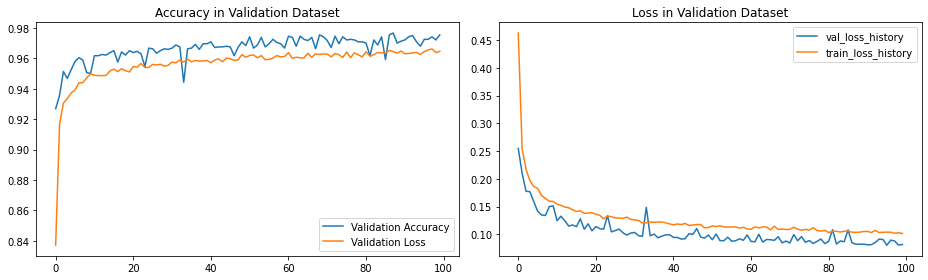


==== END ====
[[790   0   1]
 [  2 771  26]
 [  6  21 792]]

Sensitivity or recall total
0.9767538397675384

Sensitivity or recall per classes
[1.   0.96 0.97]

Precision
[0.99 0.97 0.97]

F1 Score
[0.99 0.97 0.97]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6167 Acc: 0.7876
val Loss: 0.3415 Acc: 0.9153

Epoch 1/99
----------
train Loss: 0.3027 Acc: 0.9206
val Loss: 0.2396 Acc: 0.9377

Epoch 2/99
----------
train Loss: 0.2371 Acc: 0.9343
val Loss: 0.1974 Acc: 0.9473

Epoch 3/99
----------
train Loss: 0.2028 Acc: 0.9425
val Loss: 0.1747 Acc: 0.9539

Epoch 4/99
----------
train Loss: 0.1825 Acc: 0.9474
val Loss: 0.1587 Acc: 0.9556

Epoch 5/99
----------
train Loss: 0.1696 Acc: 0.9491
val Loss: 0.1468 Acc: 0.9

train Loss: 0.0819 Acc: 0.9724
val Loss: 0.0691 Acc: 0.9784

Epoch 92/99
----------
train Loss: 0.0825 Acc: 0.9709
val Loss: 0.0694 Acc: 0.9792

Epoch 93/99
----------
train Loss: 0.0830 Acc: 0.9703
val Loss: 0.0686 Acc: 0.9788

Epoch 94/99
----------
train Loss: 0.0801 Acc: 0.9713
val Loss: 0.0681 Acc: 0.9780

Epoch 95/99
----------
train Loss: 0.0841 Acc: 0.9703
val Loss: 0.0696 Acc: 0.9784

Epoch 96/99
----------
train Loss: 0.0827 Acc: 0.9695
val Loss: 0.0679 Acc: 0.9792

Epoch 97/99
----------
train Loss: 0.0787 Acc: 0.9726
val Loss: 0.0681 Acc: 0.9797

Epoch 98/99
----------
train Loss: 0.0762 Acc: 0.9732
val Loss: 0.0676 Acc: 0.9776

Epoch 99/99
----------
train Loss: 0.0797 Acc: 0.9719
val Loss: 0.0677 Acc: 0.9780


##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 25m 47s
Best val Acc: 0.979660
##############################


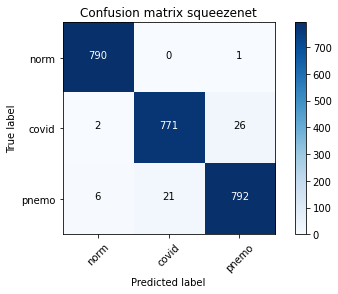

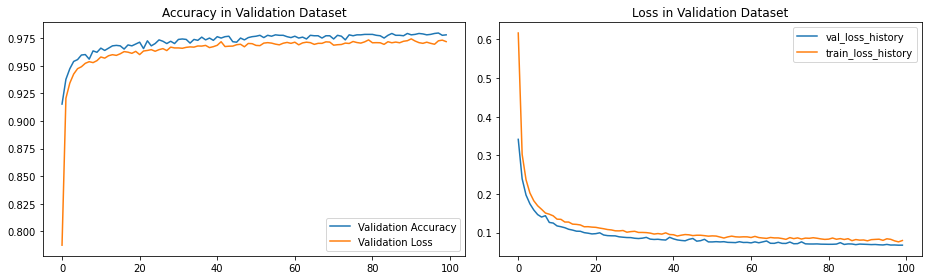


==== END ====
[[791   0   0]
 [  1 777  21]
 [  4  23 792]]

Sensitivity or recall total
0.979659609796596

Sensitivity or recall per classes
[1.   0.97 0.97]

Precision
[0.99 0.97 0.97]

F1 Score
[1.   0.97 0.97]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5616 Acc: 0.8183
val Loss: 0.2806 Acc: 0.9398

Epoch 1/99
----------
train Loss: 0.3418 Acc: 0.8962
val Loss: 0.2207 Acc: 0.9489

Epoch 2/99
----------
train Loss: 0.3008 Acc: 0.9032
val Loss: 0.1842 Acc: 0.9523

Epoch 3/99
----------
train Loss: 0.2709 Acc: 0.9111
val Loss: 0.1670 Acc: 0.9556

Epoch 4/99
----------
train Loss: 0.2627 Acc: 0.9079
val Loss: 0.1587 Acc: 0.9556

Epoch 5/99
----------
train Loss: 0.2493 Acc: 0.9174
val Loss: 0.1442 Acc: 0.9597

Ep

train Loss: 0.1643 Acc: 0.9383
val Loss: 0.0988 Acc: 0.9643

Epoch 92/99
----------
train Loss: 0.1670 Acc: 0.9373
val Loss: 0.0985 Acc: 0.9647

Epoch 93/99
----------
train Loss: 0.1700 Acc: 0.9374
val Loss: 0.0896 Acc: 0.9701

Epoch 94/99
----------
train Loss: 0.1721 Acc: 0.9376
val Loss: 0.0951 Acc: 0.9672

Epoch 95/99
----------
train Loss: 0.1652 Acc: 0.9425
val Loss: 0.0883 Acc: 0.9705

Epoch 96/99
----------
train Loss: 0.1683 Acc: 0.9398
val Loss: 0.0934 Acc: 0.9660

Epoch 97/99
----------
train Loss: 0.1615 Acc: 0.9407
val Loss: 0.0923 Acc: 0.9672

Epoch 98/99
----------
train Loss: 0.1664 Acc: 0.9398
val Loss: 0.0905 Acc: 0.9685

Epoch 99/99
----------
train Loss: 0.1654 Acc: 0.9410
val Loss: 0.0910 Acc: 0.9697


##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 74m 37s
Best val Acc: 0.971357
##############################


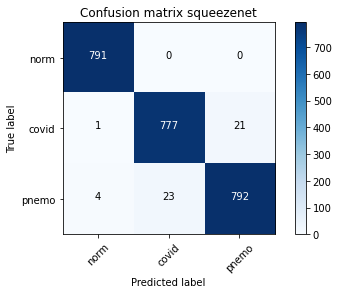

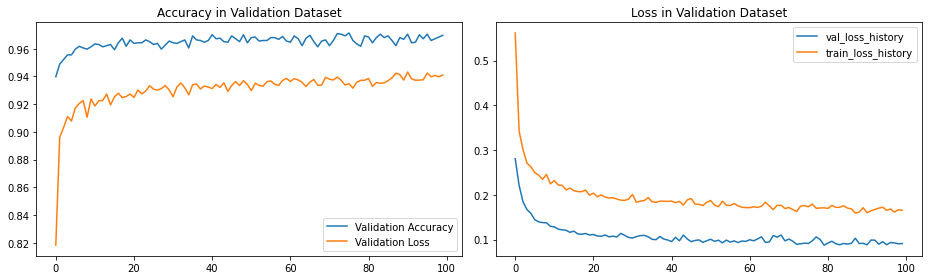


==== END ====
[[789   0   2]
 [  0 772  27]
 [  1  39 779]]

Sensitivity or recall total
0.9713574097135741

Sensitivity or recall per classes
[1.   0.97 0.95]

Precision
[1.   0.95 0.96]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6524 Acc: 0.7905
val Loss: 0.3624 Acc: 0.9298

Epoch 1/99
----------
train Loss: 0.3940 Acc: 0.8885
val Loss: 0.2492 Acc: 0.9469

Epoch 2/99
----------
train Loss: 0.3338 Acc: 0.8968
val Loss: 0.2069 Acc: 0.9498

Epoch 3/99
----------
train Loss: 0.3040 Acc: 0.9003
val Loss: 0.1839 Acc: 0.9548

Epoch 4/99
----------
train Loss: 0.2808 Acc: 0.9087
val Loss: 0.1745 Acc: 0.9510

Epoch 5/99
----------
train Loss: 0.2614 Acc: 0.9103
val Loss: 0.1561 Acc: 0.9564

E

train Loss: 0.1649 Acc: 0.9395
val Loss: 0.0911 Acc: 0.9705

Epoch 92/99
----------
train Loss: 0.1526 Acc: 0.9455
val Loss: 0.0912 Acc: 0.9701

Epoch 93/99
----------
train Loss: 0.1544 Acc: 0.9441
val Loss: 0.0839 Acc: 0.9689

Epoch 94/99
----------
train Loss: 0.1667 Acc: 0.9384
val Loss: 0.0875 Acc: 0.9685

Epoch 95/99
----------
train Loss: 0.1704 Acc: 0.9355
val Loss: 0.0864 Acc: 0.9693

Epoch 96/99
----------
train Loss: 0.1661 Acc: 0.9392
val Loss: 0.0867 Acc: 0.9709

Epoch 97/99
----------
train Loss: 0.1679 Acc: 0.9372
val Loss: 0.0856 Acc: 0.9718

Epoch 98/99
----------
train Loss: 0.1598 Acc: 0.9402
val Loss: 0.0875 Acc: 0.9689

Epoch 99/99
----------
train Loss: 0.1675 Acc: 0.9378
val Loss: 0.0901 Acc: 0.9680


##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 75m 17s
Best val Acc: 0.972603
##############################


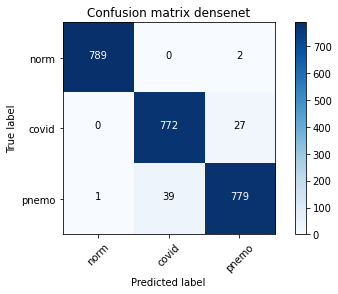

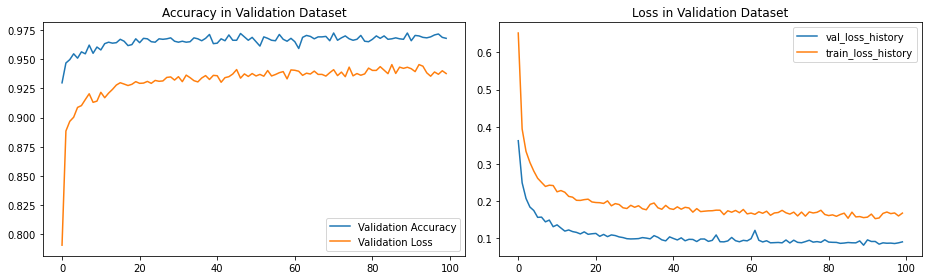


==== END ====
[[790   0   1]
 [  0 771  28]
 [  1  36 782]]

Sensitivity or recall total
0.9726027397260274

Sensitivity or recall per classes
[1.   0.96 0.95]

Precision
[1.   0.96 0.96]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5565 Acc: 0.8138
val Loss: 0.3420 Acc: 0.8937

Epoch 1/99
----------
train Loss: 0.3605 Acc: 0.8811
val Loss: 0.2467 Acc: 0.9228

Epoch 2/99
----------
train Loss: 0.3148 Acc: 0.8923
val Loss: 0.2225 Acc: 0.9274

Epoch 3/99
----------
train Loss: 0.2886 Acc: 0.8978
val Loss: 0.1822 Acc: 0.9469

Epoch 4/99
----------
train Loss: 0.2773 Acc: 0.9004
val Loss: 0.1732 Acc: 0.9473

Epoch 5/99
----------
train Loss: 0.2658 Acc: 0.9069
val Loss: 0.1665 Acc: 0.9473

Epoch 6/99
--------

train Loss: 0.1858 Acc: 0.9294
val Loss: 0.1273 Acc: 0.9527

Epoch 92/99
----------
train Loss: 0.1850 Acc: 0.9318
val Loss: 0.1103 Acc: 0.9572

Epoch 93/99
----------
train Loss: 0.1876 Acc: 0.9282
val Loss: 0.1197 Acc: 0.9539

Epoch 94/99
----------
train Loss: 0.1797 Acc: 0.9336
val Loss: 0.1158 Acc: 0.9564

Epoch 95/99
----------
train Loss: 0.1880 Acc: 0.9319
val Loss: 0.1469 Acc: 0.9431

Epoch 96/99
----------
train Loss: 0.1970 Acc: 0.9275
val Loss: 0.1108 Acc: 0.9581

Epoch 97/99
----------
train Loss: 0.1813 Acc: 0.9332
val Loss: 0.1165 Acc: 0.9568

Epoch 98/99
----------
train Loss: 0.1957 Acc: 0.9276
val Loss: 0.1417 Acc: 0.9448

Epoch 99/99
----------
train Loss: 0.1935 Acc: 0.9284
val Loss: 0.1221 Acc: 0.9543


##############################
------ Summary ------
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 26m 27s
Best val Acc: 0.960980
##############################


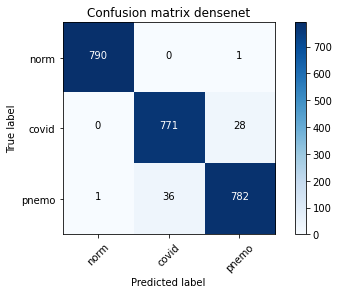

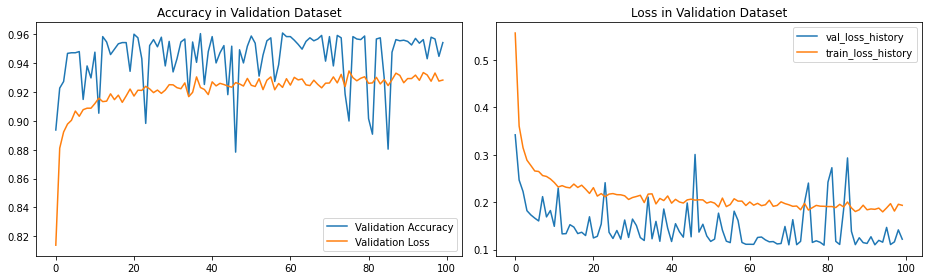


==== END ====
[[779   1  11]
 [  1 760  38]
 [  3  40 776]]

Sensitivity or recall total
0.9609796596097966

Sensitivity or recall per classes
[0.98 0.95 0.95]

Precision
[0.99 0.95 0.94]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6937 Acc: 0.7524
val Loss: 0.4089 Acc: 0.8904

Epoch 1/99
----------
train Loss: 0.4234 Acc: 0.8654
val Loss: 0.2823 Acc: 0.9170

Epoch 2/99
----------
train Loss: 0.3485 Acc: 0.8888
val Loss: 0.2301 Acc: 0.9386

Epoch 3/99
----------
train Loss: 0.3210 Acc: 0.8893
val Loss: 0.2121 Acc: 0.9352

Epoch 4/99
----------
train Loss: 0.3004 Acc: 0.8987
val Loss: 0.1957 Acc: 0.9398

Epoch 5/99
----------
train Loss: 0.2858 Acc: 0.9004
val Loss: 0.2120 Acc: 0.9232

Epoch 6/99
--------

train Loss: 0.1918 Acc: 0.9275
val Loss: 0.1431 Acc: 0.9448

Epoch 92/99
----------
train Loss: 0.1848 Acc: 0.9317
val Loss: 0.1133 Acc: 0.9548

Epoch 93/99
----------
train Loss: 0.1877 Acc: 0.9266
val Loss: 0.1110 Acc: 0.9568

Epoch 94/99
----------
train Loss: 0.1854 Acc: 0.9310
val Loss: 0.1108 Acc: 0.9585

Epoch 95/99
----------
train Loss: 0.1788 Acc: 0.9320
val Loss: 0.1160 Acc: 0.9539

Epoch 96/99
----------
train Loss: 0.1933 Acc: 0.9293
val Loss: 0.2501 Acc: 0.8983

Epoch 97/99
----------
train Loss: 0.1867 Acc: 0.9310
val Loss: 0.2439 Acc: 0.9016

Epoch 98/99
----------
train Loss: 0.1927 Acc: 0.9276
val Loss: 0.1091 Acc: 0.9601

Epoch 99/99
----------
train Loss: 0.1916 Acc: 0.9294
val Loss: 0.1429 Acc: 0.9444


##############################
------ Summary ------
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 26m 30s
Best val Acc: 0.960149
##############################


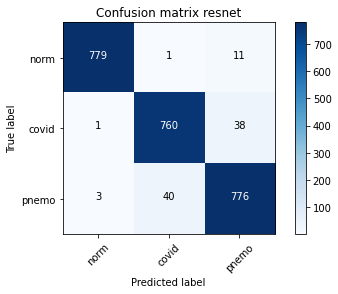

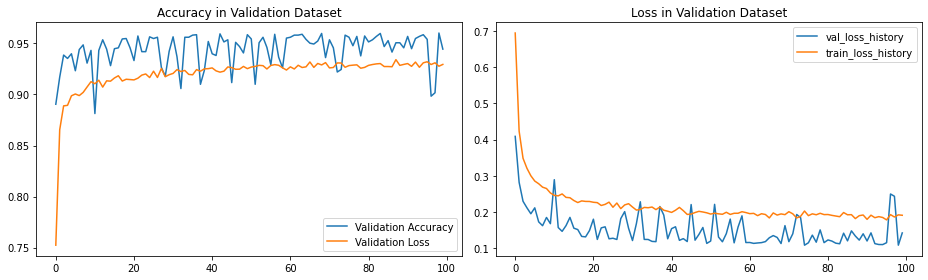


==== END ====
[[782   1   8]
 [  1 755  43]
 [  3  40 776]]

Sensitivity or recall total
0.9601494396014943

Sensitivity or recall per classes
[0.99 0.94 0.95]

Precision
[0.99 0.95 0.94]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3994 Acc: 0.8450
val Loss: 0.2498 Acc: 0.9095

Epoch 1/99
----------
train Loss: 0.3135 Acc: 0.8819
val Loss: 0.2119 Acc: 0.9319

Epoch 2/99
----------
train Loss: 0.2987 Acc: 0.8830
val Loss: 0.1955 Acc: 0.9315

Epoch 3/99
----------
train Loss: 0.2810 Acc: 0.8945
val Loss: 0.1899 Acc: 0.9323

Epoch 4/99
----------
train Loss: 0.2765 Acc: 0.8987
val Loss: 0.2149 Acc: 0.9236

Epoch 5/99
----------
train Loss: 0.2765 Acc: 0.8950
val Loss: 0.1868 Acc: 0.9319

train Loss: 0.2343 Acc: 0.9110
val Loss: 0.1610 Acc: 0.9415

Epoch 92/99
----------
train Loss: 0.2280 Acc: 0.9125
val Loss: 0.1688 Acc: 0.9361

Epoch 93/99
----------
train Loss: 0.2239 Acc: 0.9119
val Loss: 0.1673 Acc: 0.9348

Epoch 94/99
----------
train Loss: 0.2274 Acc: 0.9104
val Loss: 0.1528 Acc: 0.9423

Epoch 95/99
----------
train Loss: 0.2256 Acc: 0.9169
val Loss: 0.1552 Acc: 0.9411

Epoch 96/99
----------
train Loss: 0.2255 Acc: 0.9165
val Loss: 0.1552 Acc: 0.9431

Epoch 97/99
----------
train Loss: 0.2263 Acc: 0.9129
val Loss: 0.1566 Acc: 0.9398

Epoch 98/99
----------
train Loss: 0.2372 Acc: 0.9056
val Loss: 0.1595 Acc: 0.9377

Epoch 99/99
----------
train Loss: 0.2259 Acc: 0.9115
val Loss: 0.1417 Acc: 0.9456


##############################
------ Summary ------
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 18m 56s
Best val Acc: 0.949772
##############################


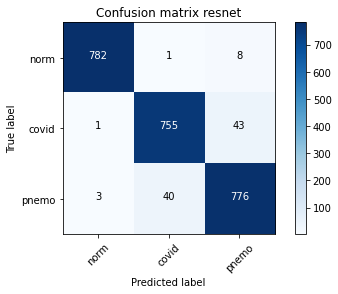

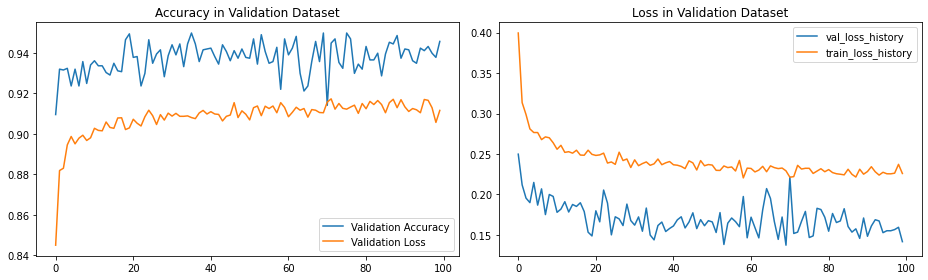


==== END ====
[[775   3  13]
 [  5 767  27]
 [ 10  63 746]]

Sensitivity or recall total
0.9497716894977168

Sensitivity or recall per classes
[0.98 0.96 0.91]

Precision
[0.98 0.92 0.95]

F1 Score
[0.98 0.94 0.93]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4463 Acc: 0.8335
val Loss: 0.2920 Acc: 0.9054

Epoch 1/99
----------
train Loss: 0.3168 Acc: 0.8842
val Loss: 0.2725 Acc: 0.9008

Epoch 2/99
----------
train Loss: 0.2896 Acc: 0.8948
val Loss: 0.2509 Acc: 0.9054

Epoch 3/99
----------
train Loss: 0.2800 Acc: 0.8966
val Loss: 0.1999 Acc: 0.9340

Epoch 4/99
----------
train Loss: 0.2718 Acc: 0.8964
val Loss: 0.2089 Acc: 0.9274

Epoch 5/99
----------
train Loss: 0.2611 Acc: 0.9037
val Loss: 0.1886 Acc: 0.9344

train Loss: 0.2051 Acc: 0.9247
val Loss: 0.1506 Acc: 0.9452

Epoch 92/99
----------
train Loss: 0.2134 Acc: 0.9199
val Loss: 0.1536 Acc: 0.9427

Epoch 93/99
----------
train Loss: 0.2098 Acc: 0.9215
val Loss: 0.1717 Acc: 0.9340

Epoch 94/99
----------
train Loss: 0.2126 Acc: 0.9188
val Loss: 0.1729 Acc: 0.9319

Epoch 95/99
----------
train Loss: 0.2092 Acc: 0.9215
val Loss: 0.1474 Acc: 0.9440

Epoch 96/99
----------
train Loss: 0.2051 Acc: 0.9209
val Loss: 0.1499 Acc: 0.9427

Epoch 97/99
----------
train Loss: 0.2082 Acc: 0.9200
val Loss: 0.1364 Acc: 0.9477

Epoch 98/99
----------
train Loss: 0.2078 Acc: 0.9221
val Loss: 0.1628 Acc: 0.9377

Epoch 99/99
----------
train Loss: 0.2085 Acc: 0.9196
val Loss: 0.1581 Acc: 0.9398


##############################
------ Summary ------
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 18m 59s
Best val Acc: 0.952262
##############################


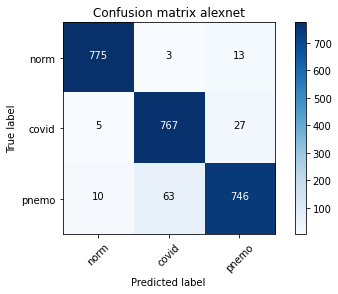

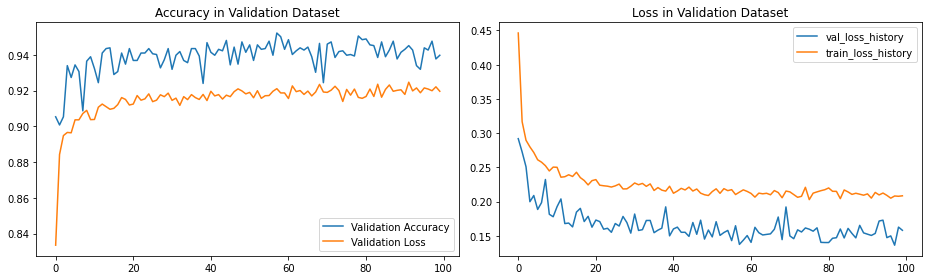


==== END ====
[[772   5  14]
 [  4 774  21]
 [  7  64 748]]

Sensitivity or recall total
0.9522623495226235

Sensitivity or recall per classes
[0.98 0.97 0.91]

Precision
[0.99 0.92 0.96]

F1 Score
[0.98 0.94 0.93]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4766 Acc: 0.8468
val Loss: 0.2457 Acc: 0.9377

Epoch 1/99
----------
train Loss: 0.2967 Acc: 0.9032
val Loss: 0.2046 Acc: 0.9402

Epoch 2/99
----------
train Loss: 0.2661 Acc: 0.9081
val Loss: 0.1844 Acc: 0.9402

Epoch 3/99
----------
train Loss: 0.2436 Acc: 0.9145
val Loss: 0.1640 Acc: 0.9469

Epoch 4/99
----------
train Loss: 0.2397 Acc: 0.9172
val Loss: 0.1581 Acc: 0.9469

Epoch 5/99
----------
train Loss: 0.2327 Acc: 0.9180
val Loss: 0.1454 Acc: 0.9531

Ep

train Loss: 0.1797 Acc: 0.9339
val Loss: 0.0985 Acc: 0.9647

Epoch 92/99
----------
train Loss: 0.1731 Acc: 0.9347
val Loss: 0.0998 Acc: 0.9655

Epoch 93/99
----------
train Loss: 0.1741 Acc: 0.9345
val Loss: 0.0976 Acc: 0.9668

Epoch 94/99
----------
train Loss: 0.1817 Acc: 0.9328
val Loss: 0.0996 Acc: 0.9676

Epoch 95/99
----------
train Loss: 0.1790 Acc: 0.9338
val Loss: 0.0997 Acc: 0.9643

Epoch 96/99
----------
train Loss: 0.1761 Acc: 0.9344
val Loss: 0.1001 Acc: 0.9680

Epoch 97/99
----------
train Loss: 0.1794 Acc: 0.9304
val Loss: 0.0974 Acc: 0.9680

Epoch 98/99
----------
train Loss: 0.1780 Acc: 0.9353
val Loss: 0.0967 Acc: 0.9655

Epoch 99/99
----------
train Loss: 0.1750 Acc: 0.9343
val Loss: 0.0957 Acc: 0.9639


##############################
------ Summary ------
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 66m 20s
Best val Acc: 0.970942
##############################


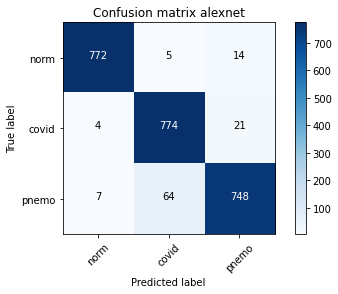

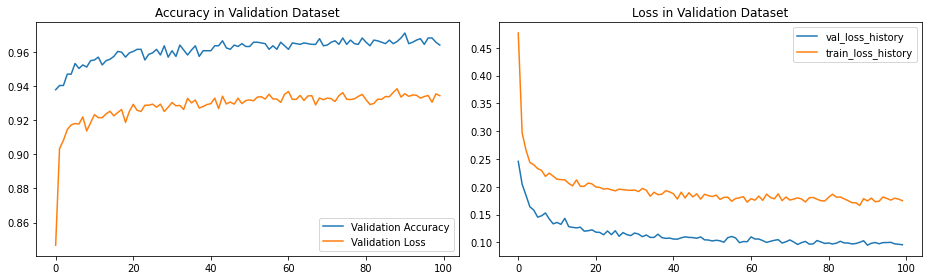


==== END ====
[[788   2   1]
 [  0 771  28]
 [  0  39 780]]

Sensitivity or recall total
0.970942299709423

Sensitivity or recall per classes
[1.   0.96 0.95]

Precision
[1.   0.95 0.96]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4173 Acc: 0.8694
val Loss: 0.2017 Acc: 0.9423

Epoch 1/99
----------
train Loss: 0.2589 Acc: 0.9094
val Loss: 0.1594 Acc: 0.9494

Epoch 2/99
----------
train Loss: 0.2395 Acc: 0.9134
val Loss: 0.1518 Acc: 0.9543

Epoch 3/99
----------
train Loss: 0.2276 Acc: 0.9191
val Loss: 0.1354 Acc: 0.9523

Epoch 4/99
----------
train Loss: 0.2188 Acc: 0.9176
val Loss: 0.1304 Acc: 0.9577

Epoch 5/99
----------
train Loss: 0.2065 Acc: 0.9258
val Loss: 0.1425 Acc: 0.9502

Epo

train Loss: 0.1744 Acc: 0.9338
val Loss: 0.0866 Acc: 0.9693

Epoch 92/99
----------
train Loss: 0.1716 Acc: 0.9316
val Loss: 0.0883 Acc: 0.9693

Epoch 93/99
----------
train Loss: 0.1648 Acc: 0.9371
val Loss: 0.0848 Acc: 0.9697

Epoch 94/99
----------
train Loss: 0.1746 Acc: 0.9347
val Loss: 0.0853 Acc: 0.9714

Epoch 95/99
----------
train Loss: 0.1665 Acc: 0.9385
val Loss: 0.0832 Acc: 0.9722

Epoch 96/99
----------
train Loss: 0.1652 Acc: 0.9364
val Loss: 0.0889 Acc: 0.9697

Epoch 97/99
----------
train Loss: 0.1706 Acc: 0.9349
val Loss: 0.0842 Acc: 0.9701

Epoch 98/99
----------
train Loss: 0.1644 Acc: 0.9373
val Loss: 0.0903 Acc: 0.9701

Epoch 99/99
----------
train Loss: 0.1610 Acc: 0.9387
val Loss: 0.0823 Acc: 0.9709


##############################
------ Summary ------
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 66m 27s
Best val Acc: 0.973018
##############################


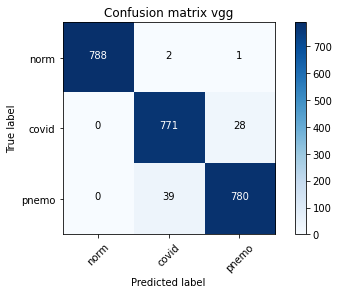

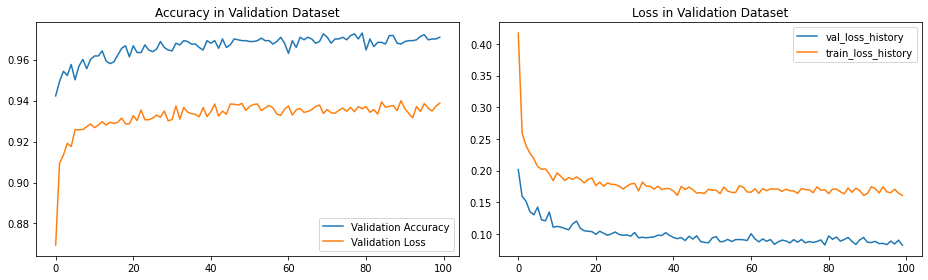


==== END ====
[[782   2   7]
 [  0 778  21]
 [  2  33 784]]

Sensitivity or recall total
0.9730178497301785

Sensitivity or recall per classes
[0.99 0.97 0.96]

Precision
[1.   0.96 0.97]

F1 Score
[0.99 0.97 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.7747 Acc: 0.7522
val Loss: 0.5273 Acc: 0.9066

Epoch 1/99
----------
train Loss: 0.5296 Acc: 0.8518
val Loss: 0.3918 Acc: 0.9207

Epoch 2/99
----------
train Loss: 0.4438 Acc: 0.8711
val Loss: 0.3225 Acc: 0.9253

Epoch 3/99
----------
train Loss: 0.4033 Acc: 0.8783
val Loss: 0.2931 Acc: 0.9236

Epoch 4/99
----------
train Loss: 0.3787 Acc: 0.8773
val Loss: 0.2779 Acc: 0.9298

Epoch 5/99
----------
train Loss: 0.3626 Acc: 0.8798
val Loss: 0.2534 Acc: 0.9319

Epoch 6/99
-----

train Loss: 0.2361 Acc: 0.9135
val Loss: 0.1289 Acc: 0.9560

Epoch 92/99
----------
train Loss: 0.2396 Acc: 0.9135
val Loss: 0.1269 Acc: 0.9568

Epoch 93/99
----------
train Loss: 0.2435 Acc: 0.9047
val Loss: 0.1261 Acc: 0.9589

Epoch 94/99
----------
train Loss: 0.2534 Acc: 0.9042
val Loss: 0.1267 Acc: 0.9581

Epoch 95/99
----------
train Loss: 0.2422 Acc: 0.9122
val Loss: 0.1320 Acc: 0.9568

Epoch 96/99
----------
train Loss: 0.2385 Acc: 0.9111
val Loss: 0.1255 Acc: 0.9585

Epoch 97/99
----------
train Loss: 0.2431 Acc: 0.9107
val Loss: 0.1241 Acc: 0.9577

Epoch 98/99
----------
train Loss: 0.2444 Acc: 0.9122
val Loss: 0.1267 Acc: 0.9597

Epoch 99/99
----------
train Loss: 0.2295 Acc: 0.9161
val Loss: 0.1276 Acc: 0.9568


##############################
------ Summary ------
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 40m 36s
Best val Acc: 0.959734
##############################


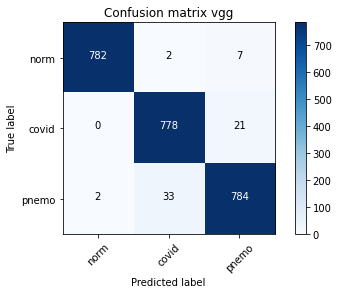

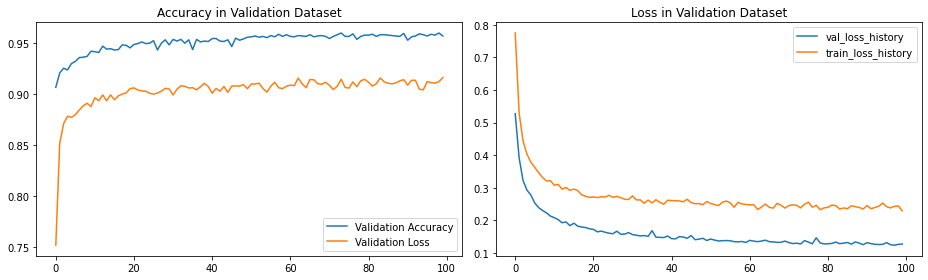


==== END ====
[[787   1   3]
 [  5 751  43]
 [  6  39 774]]

Sensitivity or recall total
0.9597343295973433

Sensitivity or recall per classes
[0.99 0.94 0.95]

Precision
[0.99 0.95 0.94]

F1 Score
[0.99 0.94 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.7310 Acc: 0.7754
val Loss: 0.4615 Acc: 0.9103

Epoch 1/99
----------
train Loss: 0.4724 Acc: 0.8642
val Loss: 0.3363 Acc: 0.9274

Epoch 2/99
----------
train Loss: 0.3966 Acc: 0.8758
val Loss: 0.2769 Acc: 0.9348

Epoch 3/99
----------
train Loss: 0.3505 Acc: 0.8856
val Loss: 0.2524 Acc: 0.9290

Epoch 4/99
----------
train Loss: 0.3267 Acc: 0.8933
val Loss: 0.2236 Acc: 0.9419

Epoch 5/99
----------
train Loss: 0.3200 Acc: 0.8884
val Loss: 0.2111 Acc: 0.9373

Epoch 6/99
-----

train Loss: 0.2330 Acc: 0.9138
val Loss: 0.1213 Acc: 0.9568

Epoch 92/99
----------
train Loss: 0.2377 Acc: 0.9078
val Loss: 0.1186 Acc: 0.9581

Epoch 93/99
----------
train Loss: 0.2222 Acc: 0.9159
val Loss: 0.1158 Acc: 0.9593

Epoch 94/99
----------
train Loss: 0.2374 Acc: 0.9102
val Loss: 0.1224 Acc: 0.9597

Epoch 95/99
----------
train Loss: 0.2400 Acc: 0.9077
val Loss: 0.1148 Acc: 0.9606

Epoch 96/99
----------
train Loss: 0.2389 Acc: 0.9087
val Loss: 0.1130 Acc: 0.9610

Epoch 97/99
----------
train Loss: 0.2282 Acc: 0.9151
val Loss: 0.1164 Acc: 0.9581

Epoch 98/99
----------
train Loss: 0.2262 Acc: 0.9152
val Loss: 0.1152 Acc: 0.9593

Epoch 99/99
----------
train Loss: 0.2283 Acc: 0.9169
val Loss: 0.1166 Acc: 0.9606


##############################
------ Summary ------
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 41m 5s
Best val Acc: 0.962640
##############################


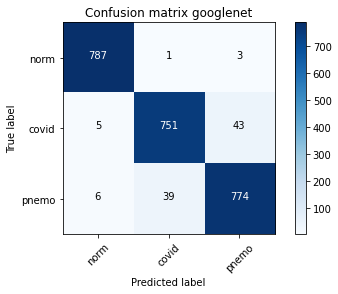

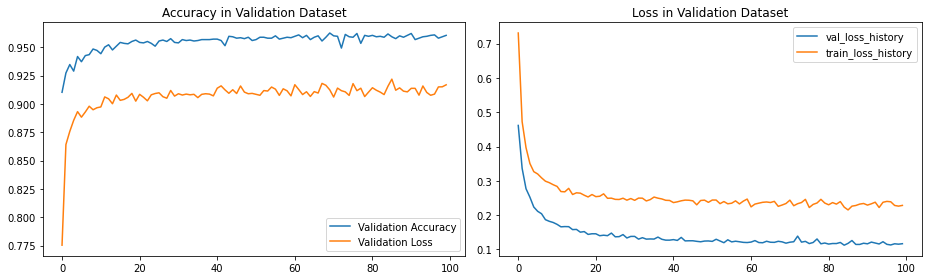


==== END ====
[[788   1   2]
 [  5 755  39]
 [  5  38 776]]

Sensitivity or recall total
0.962640099626401

Sensitivity or recall per classes
[1.   0.94 0.95]

Precision
[0.99 0.95 0.95]

F1 Score
[0.99 0.95 0.95]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0948 Acc: 0.4843
val Loss: 1.0927 Acc: 0.5479

Epoch 1/99
----------
train Loss: 1.0894 Acc: 0.5934
val Loss: 1.0892 Acc: 0.5645

Epoch 2/99
----------
train Loss: 1.0843 Acc: 0.6227
val Loss: 1.0856 Acc: 0.5309

Epoch 3/99
----------
train Loss: 1.0790 Acc: 0.6175
val Loss: 1.0757 Acc: 0.6513

Epoch 4/99
----------
train Loss: 1.0737 Acc: 0.6337
val Loss: 1.0779 Acc: 0.5434

Epoch 5/99
----------
train Loss: 1.0687 Acc: 0.6443
val Loss: 1.0718 Acc: 0.6438

Epoch 6/99
-----

train Loss: 0.7762 Acc: 0.8586
val Loss: 0.8540 Acc: 0.7410

Epoch 92/99
----------
train Loss: 0.7729 Acc: 0.8632
val Loss: 0.7975 Acc: 0.8452

Epoch 93/99
----------
train Loss: 0.7705 Acc: 0.8618
val Loss: 0.8261 Acc: 0.7837

Epoch 94/99
----------
train Loss: 0.7688 Acc: 0.8635
val Loss: 0.8438 Acc: 0.7555

Epoch 95/99
----------
train Loss: 0.7684 Acc: 0.8588
val Loss: 0.8417 Acc: 0.7534

Epoch 96/99
----------
train Loss: 0.7625 Acc: 0.8664
val Loss: 0.7770 Acc: 0.8618

Epoch 97/99
----------
train Loss: 0.7611 Acc: 0.8629
val Loss: 0.8473 Acc: 0.7543

Epoch 98/99
----------
train Loss: 0.7582 Acc: 0.8676
val Loss: 0.8165 Acc: 0.7958

Epoch 99/99
----------
train Loss: 0.7589 Acc: 0.8657
val Loss: 0.8009 Acc: 0.8045


##############################
------ Summary ------
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 38m 35s
Best val Acc: 0.908261
##############################


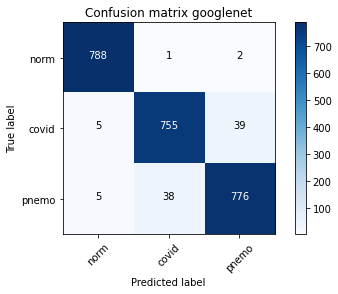

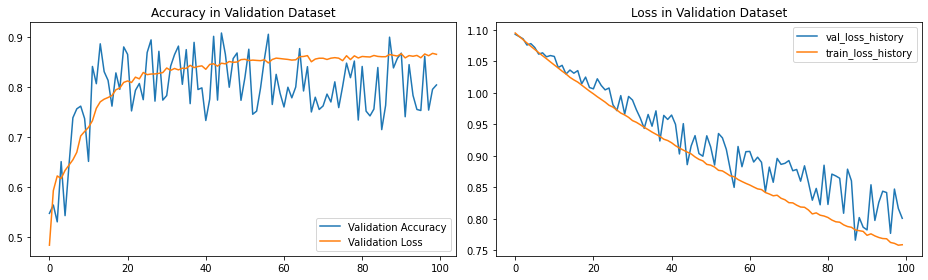


==== END ====
[[765   9  17]
 [ 10 735  54]
 [ 35  96 688]]

Sensitivity or recall total
0.9082606890826069

Sensitivity or recall per classes
[0.97 0.92 0.84]

Precision
[0.94 0.88 0.91]

F1 Score
[0.96 0.9  0.87]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0423 Acc: 0.6288
val Loss: 0.9909 Acc: 0.7696

Epoch 1/99
----------
train Loss: 0.9432 Acc: 0.7550
val Loss: 0.9020 Acc: 0.8912

Epoch 2/99
----------
train Loss: 0.8603 Acc: 0.8392
val Loss: 0.8827 Acc: 0.8746

Epoch 3/99
----------
train Loss: 0.7935 Acc: 0.8473
val Loss: 0.8231 Acc: 0.8809

Epoch 4/99
----------
train Loss: 0.7372 Acc: 0.8650
val Loss: 0.7522 Acc: 0.8825

Epoch 5/99
----------
train Loss: 0.6862 Acc: 0.8750
val Loss: 0.6438 Acc: 0.9340

Epoch 6/99
----

train Loss: 0.2367 Acc: 0.9267
val Loss: 0.2969 Acc: 0.8817

Epoch 92/99
----------
train Loss: 0.2334 Acc: 0.9273
val Loss: 0.1771 Acc: 0.9514

Epoch 93/99
----------
train Loss: 0.2362 Acc: 0.9250
val Loss: 0.2672 Acc: 0.8995

Epoch 94/99
----------
train Loss: 0.2364 Acc: 0.9242
val Loss: 0.1602 Acc: 0.9564

Epoch 95/99
----------
train Loss: 0.2383 Acc: 0.9245
val Loss: 0.1987 Acc: 0.9440

Epoch 96/99
----------
train Loss: 0.2346 Acc: 0.9260
val Loss: 0.2608 Acc: 0.9062

Epoch 97/99
----------
train Loss: 0.2390 Acc: 0.9203
val Loss: 0.1782 Acc: 0.9543

Epoch 98/99
----------
train Loss: 0.2327 Acc: 0.9252
val Loss: 0.3505 Acc: 0.8460

Epoch 99/99
----------
train Loss: 0.2322 Acc: 0.9301
val Loss: 0.3520 Acc: 0.8472


##############################
------ Summary ------
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 39m 5s
Best val Acc: 0.956413
##############################


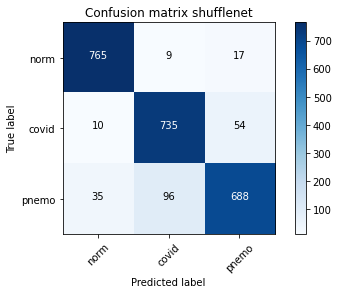

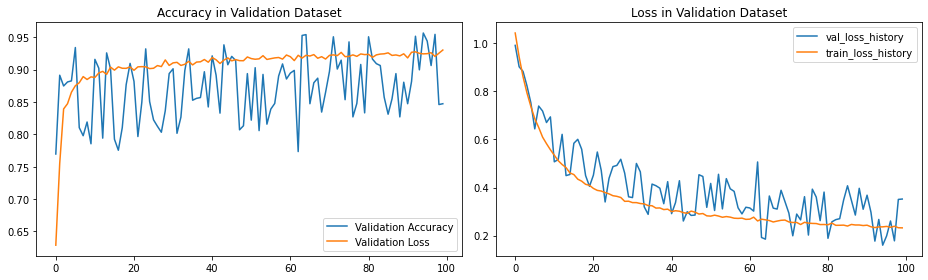


==== END ====
[[788   0   3]
 [  5 754  40]
 [  1  56 762]]

Sensitivity or recall total
0.9564134495641345

Sensitivity or recall per classes
[1.   0.94 0.93]

Precision
[0.99 0.93 0.95]

F1 Score
[0.99 0.94 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5230 Acc: 0.8355
val Loss: 0.2465 Acc: 0.9506

Epoch 1/99
----------
train Loss: 0.3231 Acc: 0.8957
val Loss: 0.1805 Acc: 0.9523

Epoch 2/99
----------
train Loss: 0.2835 Acc: 0.9040
val Loss: 0.1514 Acc: 0.9581

Epoch 3/99
----------
train Loss: 0.2645 Acc: 0.9114
val Loss: 0.1430 Acc: 0.9577

Epoch 4/99
----------
train Loss: 0.2526 Acc: 0.9113
val Loss: 0.1423 Acc: 0.9589

Epoch 5/99
----------
train Loss: 0.2425 Acc: 0.9143
val Loss: 0.1316 Acc: 0.96

train Loss: 0.1953 Acc: 0.9279
val Loss: 0.0956 Acc: 0.9697

Epoch 92/99
----------
train Loss: 0.1981 Acc: 0.9244
val Loss: 0.0889 Acc: 0.9685

Epoch 93/99
----------
train Loss: 0.1901 Acc: 0.9259
val Loss: 0.0864 Acc: 0.9718

Epoch 94/99
----------
train Loss: 0.2048 Acc: 0.9235
val Loss: 0.0850 Acc: 0.9709

Epoch 95/99
----------
train Loss: 0.1988 Acc: 0.9265
val Loss: 0.0875 Acc: 0.9701

Epoch 96/99
----------
train Loss: 0.1998 Acc: 0.9259
val Loss: 0.0898 Acc: 0.9714

Epoch 97/99
----------
train Loss: 0.1911 Acc: 0.9273
val Loss: 0.0912 Acc: 0.9693

Epoch 98/99
----------
train Loss: 0.1856 Acc: 0.9322
val Loss: 0.0888 Acc: 0.9701

Epoch 99/99
----------
train Loss: 0.1837 Acc: 0.9304
val Loss: 0.0896 Acc: 0.9680


##############################
------ Summary ------
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 34m 15s
Best val Acc: 0.971773
##############################


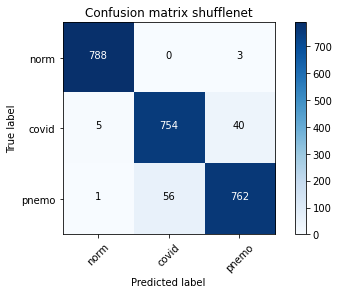

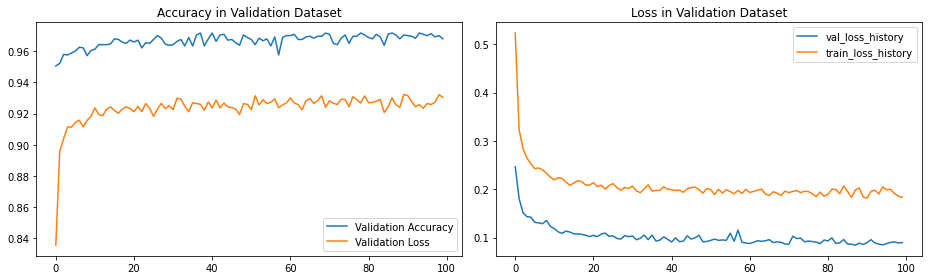


==== END ====
[[791   0   0]
 [  0 768  31]
 [  1  36 782]]

Sensitivity or recall total
0.9717725197177252

Sensitivity or recall per classes
[1.   0.96 0.95]

Precision
[1.   0.96 0.96]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5470 Acc: 0.8364
val Loss: 0.2508 Acc: 0.9473

Epoch 1/99
----------
train Loss: 0.3176 Acc: 0.9005
val Loss: 0.1811 Acc: 0.9539

Epoch 2/99
----------
train Loss: 0.2809 Acc: 0.9046
val Loss: 0.1652 Acc: 0.9514

Epoch 3/99
----------
train Loss: 0.2508 Acc: 0.9125
val Loss: 0.1440 Acc: 0.9548

Epoch 4/99
----------
train Loss: 0.2597 Acc: 0.9047
val Loss: 0.1440 Acc: 0.9564

Epoch 5/99
----------
train Loss: 0.2349 Acc: 0.9146
val Loss: 0.1260 Acc: 0.96

train Loss: 0.1831 Acc: 0.9285
val Loss: 0.0860 Acc: 0.9689

Epoch 92/99
----------
train Loss: 0.1902 Acc: 0.9289
val Loss: 0.0967 Acc: 0.9643

Epoch 93/99
----------
train Loss: 0.1857 Acc: 0.9270
val Loss: 0.0851 Acc: 0.9714

Epoch 94/99
----------
train Loss: 0.1885 Acc: 0.9281
val Loss: 0.0913 Acc: 0.9697

Epoch 95/99
----------
train Loss: 0.1881 Acc: 0.9289
val Loss: 0.0860 Acc: 0.9689

Epoch 96/99
----------
train Loss: 0.1895 Acc: 0.9256
val Loss: 0.0829 Acc: 0.9718

Epoch 97/99
----------
train Loss: 0.1850 Acc: 0.9300
val Loss: 0.0899 Acc: 0.9693

Epoch 98/99
----------
train Loss: 0.1909 Acc: 0.9256
val Loss: 0.0844 Acc: 0.9709

Epoch 99/99
----------
train Loss: 0.1857 Acc: 0.9275
val Loss: 0.0847 Acc: 0.9709


##############################
------ Summary ------
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 34m 36s
Best val Acc: 0.973018
##############################


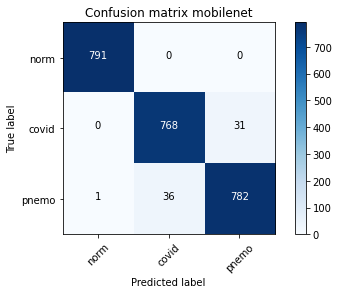

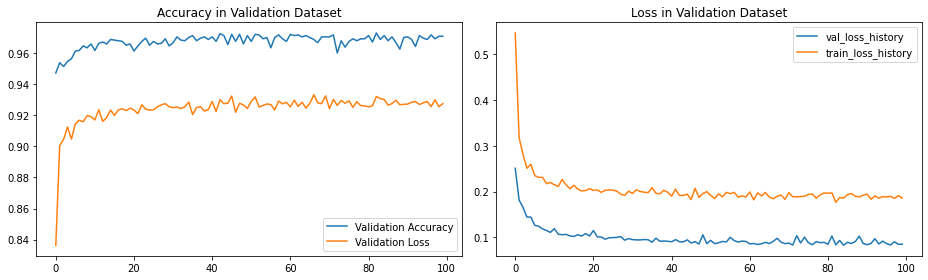


==== END ====
[[791   0   0]
 [  0 769  30]
 [  0  35 784]]

Sensitivity or recall total
0.9730178497301785

Sensitivity or recall per classes
[1.   0.96 0.96]

Precision
[1.   0.96 0.96]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization


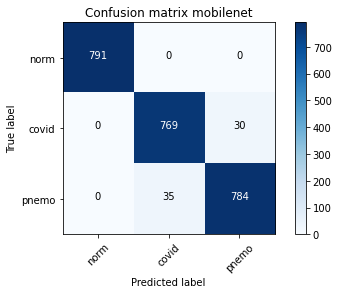

In [31]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg', 'googlenet', 'shufflenet', 'mobilenet' ]
lrs = [1e-4]
_epoch = [100]
batch_sizes = [8]
opt = [1, 2]
crt = [1]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                         
                        
                            
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        
                        
                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
#                         if _opt == 3:
#                             optimizer_ft = optim.RMSprop(params_to_update, _lrs)
#                             opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
#                         if _crt == 2:
#                             criterion = nn.NLLLoss()
#                             crt_name = 'NLLLoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)
                        
                        

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], 
                        title='Confusion matrix '+_model)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [42]:
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke